## Weather Prediction:  A comparision of traditional and modern methods

In this study, we are going to use Python and Machine Learning to build models to predict weather temperatures based off data from WorldWeatherOnline. There are three "phases" to this study:

1. Data collection and processing (i.e. like doing an experiment!)
2. Using Linear Regression models (i.e. a traditional fitting approach)
3. Using Neural Network models (i.e. a machine-learning approach)

The data used will be collected from the WorldWeatherOnline API web services. We will interact with the API to pull in weather data over a given time period, for a given location.

Once collected, the data will need to be processed and aggregated into a format that is suitable for data analysis, and then cleaned.

In [1]:
# import the usual libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# We are going to need several additional libraries.  We import them here, but
# I will discuss their purpose and give further details as they are used.

dark_mode = True
# plotting choices for dark-mode ... comment out if not using dark mode!!!
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

In [2]:
import os
os.chdir("/home/brash/Phys421/WWO")
df1 = pd.read_csv('regina.csv')
df2 = pd.read_csv('regina_2018.csv')
df3 = pd.read_csv('regina_2017.csv')

In [3]:
# Create new feature columns ... the idea is that we are going to
# try to predict the temperature for tomorrow by looking at what
# happened today, and for the past three days.

# For each feature that we think might be an important factor in
# determining out temperature forecast, we will add a column to the
# dataframe for this variable for each of the previous three days.
#
# The factor 8*N takes into account that the data in our dataframe
# is reported once every three hours (or 8 times per day)

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*8*N + [df[feature][i-8*N] for i in range(8*N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [4]:
# These are the features/variables that we think a priori might be
# important in our forecasting model

features = ["date_time", "tempC", "DewPointC","pressure","humidity",
            "maxtempC", "mintempC", "sunHour", "windspeedKmph",
            "winddirDegree","precipMM"]


In [5]:
# Now, for each of these features, add three new columns to the
# dataframe which correspond to yesterday, the day before yesterday,
# and the day before that.  The column names will be the same as
# the name as the original feature, but with _1, _2, or _3 added on.

for feature in features:
    if feature != 'date_time':
        for N in range(1, 4):
            derive_nth_day_feature(df1, feature, N)
            derive_nth_day_feature(df2, feature, N)
            derive_nth_day_feature(df3, feature, N)

In [6]:
# We see now that we have accomplished our task ... a lot of new
# columns have been added!

df1.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,6.320548,-1.304110,0.096986,9.662740,2.778082,45.084932,-2.838014,-0.770548,2.878082,-0.827740,...,9.672928,15.394574,15.407369,15.426796,208.945398,208.695592,208.353591,0.246291,0.246970,0.247652
std,15.216829,13.729361,0.388413,4.160689,1.682609,31.265919,12.333195,17.486786,14.668713,17.401909,...,4.176386,6.757152,6.760687,6.759334,94.242035,94.249179,94.153133,1.124402,1.125876,1.127356
min,-28.000000,-36.000000,0.000000,3.000000,1.000000,0.000000,-40.000000,-46.000000,-36.000000,-46.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-6.000000,-12.000000,0.000000,5.900000,1.000000,17.000000,-10.000000,-14.000000,-8.000000,-14.000000,...,5.900000,10.000000,10.000000,10.000000,130.000000,129.000000,129.000000,0.000000,0.000000,0.000000
50%,8.000000,1.000000,0.000000,9.200000,2.000000,44.000000,-2.000000,1.000000,4.000000,1.000000,...,9.300000,14.000000,14.000000,14.000000,217.000000,216.500000,216.000000,0.000000,0.000000,0.000000
75%,20.000000,11.000000,0.000000,13.500000,4.000000,72.000000,7.000000,14.000000,15.000000,14.000000,...,13.500000,19.000000,19.000000,19.000000,297.000000,297.000000,296.000000,0.000000,0.000000,0.000000
max,32.000000,21.000000,3.400000,16.700000,7.000000,100.000000,19.000000,33.000000,33.000000,31.000000,...,16.700000,46.000000,46.000000,46.000000,358.000000,358.000000,358.000000,33.400000,33.400000,33.400000


In [7]:
df2.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,7.824658,-0.356164,0.069041,10.023836,2.969863,46.734247,-2.088014,0.217808,3.687329,0.176712,...,10.060773,15.223214,15.208678,15.222030,206.478365,206.871212,206.910221,0.054808,0.054855,0.055007
std,14.710897,13.226122,0.403412,4.281772,1.898174,31.277963,10.512825,17.124911,14.409367,17.075983,...,4.275437,7.548558,7.552858,7.556585,94.994980,94.821063,94.883997,0.474435,0.475059,0.475706
min,-23.000000,-29.000000,0.000000,3.000000,1.000000,0.000000,-30.000000,-38.000000,-29.000000,-38.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.000000,-11.000000,0.000000,6.700000,1.000000,19.000000,-9.000000,-13.000000,-7.000000,-13.000000,...,6.700000,10.000000,10.000000,10.000000,136.000000,136.000000,136.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,0.000000,10.100000,2.000000,46.000000,-2.000000,-1.000000,2.000000,-1.000000,...,10.100000,14.000000,14.000000,14.000000,209.000000,209.000000,209.000000,0.000000,0.000000,0.000000
75%,22.000000,12.000000,0.000000,14.500000,5.000000,74.000000,7.000000,16.000000,16.000000,16.000000,...,14.500000,20.000000,20.000000,20.000000,293.000000,293.000000,294.000000,0.000000,0.000000,0.000000
max,41.000000,23.000000,4.300000,16.700000,8.000000,100.000000,21.000000,41.000000,41.000000,41.000000,...,16.700000,42.000000,42.000000,42.000000,360.000000,360.000000,360.000000,13.500000,13.500000,13.500000


In [8]:
df3.describe

<bound method NDFrame.describe of                 date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0     2017-01-01 00:00:00       -14       -19           0.0      6.9        1   
1     2017-01-01 03:00:00       -14       -19           0.0      6.9        1   
2     2017-01-01 06:00:00       -14       -19           0.0      6.9        1   
3     2017-01-01 09:00:00       -14       -19           0.0      6.9        1   
4     2017-01-01 12:00:00       -14       -19           0.0      6.9        1   
...                   ...       ...       ...           ...      ...      ...   
2915  2017-12-31 09:00:00       -23       -29           0.0      3.2        1   
2916  2017-12-31 12:00:00       -23       -29           0.0      3.2        1   
2917  2017-12-31 15:00:00       -23       -29           0.0      3.2        1   
2918  2017-12-31 18:00:00       -23       -29           0.0      3.2        1   
2919  2017-12-31 21:00:00       -23       -29           0.0      3.2       

In [9]:
# We now want to clean up the dataframe, and get rid of columns that
# we are not interested in.  This is not so important in this example,
# but if we are dealing with large dataframes with thousands of columns
# of data, it can really speed things up by condensing things.

# make list of original features we are not interested in
to_remove = [feature 
             for feature in features 
             if feature not in ['date_time','maxtempC', 'mintempC', 'tempC']]
for col in ['DewPointC','pressure','humidity','sunHour',
                'windspeedKmph','winddirDegree','precipMM',
                 'totalSnow_cm','uvIndex','moon_illumination',
                  'moonrise','moonset','sunrise','sunset','FeelsLikeC',
                 'HeatIndexC','WindChillC','WindGustKmph','cloudcover',
                 'visibility','location']:
    to_remove.append(col)

print(to_remove)

# make a list of columns to keep
to_keep = [col for col in df1.columns if col not in to_remove]

print(to_keep)

# select only the columns in to_keep and assign to df
df1 = df1[to_keep]
df2 = df2[to_keep]
df3 = df3[to_keep]

['DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'totalSnow_cm', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'visibility', 'location']
['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2', 'precipMM_3']


In [10]:
df1.head()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
0,2019-01-01 00:00:00,-12,-26,-28,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 03:00:00,-12,-26,-28,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 06:00:00,-12,-26,-27,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 09:00:00,-12,-26,-24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 12:00:00,-12,-26,-18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# the last task is to convert the date_time column from an object into a floating point number
# there are a number of ways that we could do this

df1['date'] = pd.to_datetime(df1['date_time'])    
df1['date_delta'] = (df1['date'] - df1['date'].min())  / np.timedelta64(1,'D')

df2['date'] = pd.to_datetime(df2['date_time'])    
df2['date_delta'] = (df2['date'] - df2['date'].min())  / np.timedelta64(1,'D')

df3['date'] = pd.to_datetime(df3['date_time'])    
df3['date_delta'] = (df3['date'] - df3['date'].min())  / np.timedelta64(1,'D')


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [12]:
df2.head()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date,date_delta
0,2018-01-01 00:00:00,-20,-26,-26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,0.000
1,2018-01-01 03:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 03:00:00,0.125
2,2018-01-01 06:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 06:00:00,0.250
3,2018-01-01 09:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 09:00:00,0.375
4,2018-01-01 12:00:00,-20,-26,-22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 12:00:00,0.500


In [13]:
# Now, let's get rid of the rows that do not have complete data!

df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()

## We are now ready to do a linear regression fit to the data!!

In [14]:
# for our model, we will only include variables where the abs(r) > 0.4 - that is, either
# a strong positive or strong negative correlation.

predictors = ['tempC_1',  'DewPointC_1',  'maxtempC_1', 
              'mintempC_1',   'tempC_2',   'DewPointC_2',
              'maxtempC_2', 'mintempC_2', 'tempC_3',
              'DewPointC_3',  'mintempC_3',  'maxtempC_3',
              'pressure_1',  'pressure_2',  'pressure_3',
              'humidity_1',   'humidity_2', 'humidity_3',
              'sunHour_1', 'sunHour_2', 'sunHour_3']
df12 = df1[['date_delta']+['tempC'] + predictors]
df22 = df2[['date_delta']+['tempC'] + predictors]
df32 = df3[['date_delta']+['tempC'] + predictors]

In [15]:
# separate our my predictor variables (X) from my outcome variable y
Xtrain = df12[predictors+['date_delta']]
ytrain = df12['tempC']
Xtest = df22[predictors+['date_delta']]
ytest = df22['tempC']
Xval = df32[predictors+['date_delta']]
yval = df32['tempC']

## OK, so I lied ... now we are REALLY read to do the linear regression fit!  We had to prepare the data a bit more, didn't we?

In [16]:
print("Training instances   {}, Training features   {}".format(Xtrain.shape[0], Xtrain.shape[1]))
print("Validation instances {}, Validation features {}".format(Xval.shape[0], Xval.shape[1]))
print("Testing instances    {}, Testing features    {}".format(Xtest.shape[0], Xtest.shape[1]))

Training instances   2896, Training features   22
Validation instances 2896, Validation features 22
Testing instances    2896, Testing features    22


In [17]:
import tensorflow as tf

In [18]:
feature_cols = [tf.feature_column.numeric_column(col) for col in Xtrain.columns]

In [19]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [20]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [21]:
evaluations = []
STEPS = 400
for i in range(100):
    regressor.train(input_fn=wx_input_fn(Xtrain, y=ytrain), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(Xval,
                                                               yval,
                                                               num_epochs=1,
                                                               shuffle=False)))


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-40000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40000...
INFO:tensorflow:Saving c

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-41200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41200...
INFO:tensorflow:Saving checkpoints for 41200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41200...
INFO:tensorflow:loss = 20.160995, step = 41200
INFO:tensorflow:global_step/sec: 66.3357
INFO:tensorflow:loss = 18.118885, step = 41300 (1.511 sec)
INFO:tensorflow:global_step/sec: 68.9277
INFO:tensorflow:loss = 13.761288, step = 41400 (1.451 sec)
INFO:tensorflow:global_step/sec: 71.3003
INFO:tensorflow:loss = 15.788344, step = 41500 (1.402 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41600...
INFO:tensorflow:Saving checkpoints for 41600 into tf_wx_model/model.c

INFO:tensorflow:loss = 17.304323, step = 43100 (1.446 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 43200...
INFO:tensorflow:Saving checkpoints for 43200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 43200...
INFO:tensorflow:Loss for final step: 16.868202.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T07:57:00Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-43200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.30321s
INFO:tensorflow:Finished evaluation at 2021-05-17-07:57:01
INFO:tensorflow:Saving dict for global step 43200: average_loss = 23.093685, global_step = 43200, label/mean = 5.5051794, loss = 24.45827, prediction/mean = 4.9730067
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 43200

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 44800: tf_wx_model/model.ckpt-44800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-44800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44800...
INFO:tensorflow:Saving checkpoints for 44800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44800...
INFO:tensorflow:loss = 14.653232, step = 44800
INFO:tensorflow:global_step/sec: 71.3265
INFO:tensorflow:loss = 20.930576, step = 44900 (1.405 sec)
INFO:tensorflow:global_step/sec: 68.6916
INFO:tensorflow:loss = 17.914925, step = 45000 (1.456 sec)
INFO:tensorflow:global_step/sec: 73.8121
INFO:tensorflow:loss = 14.162527, step = 45100 (1.355 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 63.9915
INFO:tensorflow:loss = 17.437622, step = 46600 (1.563 sec)
INFO:tensorflow:global_step/sec: 72.4712
INFO:tensorflow:loss = 13.8226185, step = 46700 (1.380 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 46800...
INFO:tensorflow:Saving checkpoints for 46800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46800...
INFO:tensorflow:Loss for final step: 14.934834.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T07:58:04Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-46800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.30276s
INFO:tensorflow:Finished evaluation at 2021-05-17-07:58:05
INFO:tensorflow:Saving dict for global step 46800: average_loss = 22.896511, global_step = 4680

INFO:tensorflow:Inference Time : 0.28970s
INFO:tensorflow:Finished evaluation at 2021-05-17-07:58:33
INFO:tensorflow:Saving dict for global step 48400: average_loss = 22.601833, global_step = 48400, label/mean = 5.5051794, loss = 24.136871, prediction/mean = 5.0672846
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 48400: tf_wx_model/model.ckpt-48400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-48400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48400...
INFO:tensorflow:Saving checkpoints for 48400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48400...
INFO:tensorflow:loss = 15.539109, step = 48400
INFO:tensorflow:global_step/sec: 67.7095
INF

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50000...
INFO:tensorflow:loss = 17.674723, step = 50000
INFO:tensorflow:global_step/sec: 66.5974
INFO:tensorflow:loss = 15.103032, step = 50100 (1.504 sec)
INFO:tensorflow:global_step/sec: 73.2938
INFO:tensorflow:loss = 15.335014, step = 50200 (1.365 sec)
INFO:tensorflow:global_step/sec: 72.6901
INFO:tensorflow:loss = 18.827856, step = 50300 (1.376 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50400...
INFO:tensorflow:Saving checkpoints for 50400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50400...
INFO:tensorflow:Loss for final step: 13.404258.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T07:59:08Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-50400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:

INFO:tensorflow:Starting evaluation at 2021-05-17T07:59:37Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-52000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.29544s
INFO:tensorflow:Finished evaluation at 2021-05-17-07:59:37
INFO:tensorflow:Saving dict for global step 52000: average_loss = 22.510172, global_step = 52000, label/mean = 5.5051794, loss = 23.990093, prediction/mean = 4.9516096
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 52000: tf_wx_model/model.ckpt-52000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-52000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-53600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 53600...
INFO:tensorflow:Saving checkpoints for 53600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 53600...
INFO:tensorflow:loss = 14.280255, step = 53600
INFO:tensorflow:global_step/sec: 70.5216
INFO:tensorflow:loss = 14.611985, step = 53700 (1.421 sec)
INFO:tensorflow:global_step/sec: 67.6782
INFO:tensorflow:loss = 19.527199, step = 53800 (1.477 sec)
INFO:tensorflow:global_step/sec: 76.4154
INFO:tensorflow:loss = 16.24482, step = 53900 (1.309 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54000...
INFO:tensorflow:Saving checkpoints for 54000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54000...
INFO:tensorflow:Loss for final step: 1

INFO:tensorflow:Saving checkpoints for 55600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55600...
INFO:tensorflow:Loss for final step: 15.266069.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T08:00:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-55600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.29500s
INFO:tensorflow:Finished evaluation at 2021-05-17-08:00:40
INFO:tensorflow:Saving dict for global step 55600: average_loss = 22.440697, global_step = 55600, label/mean = 5.5051794, loss = 23.899532, prediction/mean = 4.8669276
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 55600: tf_wx_model/model.ckpt-55600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkpoint

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 57200: tf_wx_model/model.ckpt-57200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-57200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 57200...
INFO:tensorflow:Saving checkpoints for 57200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 57200...
INFO:tensorflow:loss = 14.169248, step = 57200
INFO:tensorflow:global_step/sec: 67.517
INFO:tensorflow:loss = 13.5419235, step = 57300 (1.484 sec)
INFO:tensorflow:global_step/sec: 60.2576
INFO:tensorflow:loss = 17.6055, step = 57400 (1.659 sec)
INFO:tensorflow:global_step/sec: 70.1917
INFO:tensorflow:loss = 21.082329, step = 57500 (1.425 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 66.8711
INFO:tensorflow:loss = 18.611395, step = 59000 (1.495 sec)
INFO:tensorflow:global_step/sec: 66.7558
INFO:tensorflow:loss = 18.01316, step = 59100 (1.498 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 59200...
INFO:tensorflow:Saving checkpoints for 59200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 59200...
INFO:tensorflow:Loss for final step: 14.726937.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T08:01:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-59200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.29398s
INFO:tensorflow:Finished evaluation at 2021-05-17-08:01:45
INFO:tensorflow:Saving dict for global step 59200: average_loss = 22.072615, global_step = 59200,

INFO:tensorflow:Inference Time : 0.28847s
INFO:tensorflow:Finished evaluation at 2021-05-17-08:02:13
INFO:tensorflow:Saving dict for global step 60800: average_loss = 21.99707, global_step = 60800, label/mean = 5.5051794, loss = 23.695091, prediction/mean = 5.0484314
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60800: tf_wx_model/model.ckpt-60800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-60800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60800...
INFO:tensorflow:Saving checkpoints for 60800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60800...
INFO:tensorflow:loss = 17.5194, step = 60800
INFO:tensorflow:global_step/sec: 67.8495
INFO:t

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62400...
INFO:tensorflow:loss = 14.466599, step = 62400
INFO:tensorflow:global_step/sec: 65.1725
INFO:tensorflow:loss = 15.03461, step = 62500 (1.537 sec)
INFO:tensorflow:global_step/sec: 64.1793
INFO:tensorflow:loss = 15.62055, step = 62600 (1.558 sec)
INFO:tensorflow:global_step/sec: 63.8573
INFO:tensorflow:loss = 14.791791, step = 62700 (1.566 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62800...
INFO:tensorflow:Saving checkpoints for 62800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62800...
INFO:tensorflow:Loss for final step: 15.008057.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T08:02:48Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-62800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Do

INFO:tensorflow:Starting evaluation at 2021-05-17T08:03:16Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-64400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.28316s
INFO:tensorflow:Finished evaluation at 2021-05-17-08:03:17
INFO:tensorflow:Saving dict for global step 64400: average_loss = 21.965864, global_step = 64400, label/mean = 5.5051794, loss = 23.618147, prediction/mean = 4.942594
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 64400: tf_wx_model/model.ckpt-64400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-64400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 64

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-66000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 66000...
INFO:tensorflow:Saving checkpoints for 66000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66000...
INFO:tensorflow:loss = 15.886588, step = 66000
INFO:tensorflow:global_step/sec: 72.8475
INFO:tensorflow:loss = 13.241712, step = 66100 (1.375 sec)
INFO:tensorflow:global_step/sec: 73.9224
INFO:tensorflow:loss = 15.247944, step = 66200 (1.353 sec)
INFO:tensorflow:global_step/sec: 69.568
INFO:tensorflow:loss = 17.826513, step = 66300 (1.438 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 66400...
INFO:tensorflow:Saving checkpoints for 66400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66400...
INFO:tensorflow:Loss for final step: 1

INFO:tensorflow:Saving checkpoints for 68000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68000...
INFO:tensorflow:Loss for final step: 13.785984.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T08:04:20Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-68000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.26437s
INFO:tensorflow:Finished evaluation at 2021-05-17-08:04:20
INFO:tensorflow:Saving dict for global step 68000: average_loss = 21.79659, global_step = 68000, label/mean = 5.5051794, loss = 23.49872, prediction/mean = 4.9692574
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 68000: tf_wx_model/model.ckpt-68000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSa

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 69600: tf_wx_model/model.ckpt-69600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-69600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69600...
INFO:tensorflow:Saving checkpoints for 69600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69600...
INFO:tensorflow:loss = 16.697882, step = 69600
INFO:tensorflow:global_step/sec: 62.814
INFO:tensorflow:loss = 16.042583, step = 69700 (1.595 sec)
INFO:tensorflow:global_step/sec: 66.897
INFO:tensorflow:loss = 14.936719, step = 69800 (1.495 sec)
INFO:tensorflow:global_step/sec: 70.7756
INFO:tensorflow:loss = 18.748533, step = 69900 (1.414 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 67.1365
INFO:tensorflow:loss = 14.339058, step = 71400 (1.487 sec)
INFO:tensorflow:global_step/sec: 68.8547
INFO:tensorflow:loss = 16.144604, step = 71500 (1.452 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 71600...
INFO:tensorflow:Saving checkpoints for 71600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 71600...
INFO:tensorflow:Loss for final step: 20.634499.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T08:05:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-71600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.29047s
INFO:tensorflow:Finished evaluation at 2021-05-17-08:05:24
INFO:tensorflow:Saving dict for global step 71600: average_loss = 21.696423, global_step = 71600

INFO:tensorflow:Inference Time : 0.28994s
INFO:tensorflow:Finished evaluation at 2021-05-17-08:05:53
INFO:tensorflow:Saving dict for global step 73200: average_loss = 21.525337, global_step = 73200, label/mean = 5.5051794, loss = 23.429909, prediction/mean = 5.0733004
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 73200: tf_wx_model/model.ckpt-73200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-73200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 73200...
INFO:tensorflow:Saving checkpoints for 73200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 73200...
INFO:tensorflow:loss = 12.295725, step = 73200
INFO:tensorflow:global_step/sec: 70.1184
INF

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 74800...
INFO:tensorflow:loss = 13.005832, step = 74800
INFO:tensorflow:global_step/sec: 70.2497
INFO:tensorflow:loss = 12.767225, step = 74900 (1.427 sec)
INFO:tensorflow:global_step/sec: 68.558
INFO:tensorflow:loss = 18.438866, step = 75000 (1.458 sec)
INFO:tensorflow:global_step/sec: 71.7073
INFO:tensorflow:loss = 15.079076, step = 75100 (1.394 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75200...
INFO:tensorflow:Saving checkpoints for 75200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75200...
INFO:tensorflow:Loss for final step: 13.933619.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-05-17T08:06:29Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-75200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:D

INFO:tensorflow:Starting evaluation at 2021-05-17T08:06:57Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-76800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.30363s
INFO:tensorflow:Finished evaluation at 2021-05-17-08:06:57
INFO:tensorflow:Saving dict for global step 76800: average_loss = 21.564089, global_step = 76800, label/mean = 5.5051794, loss = 23.34625, prediction/mean = 4.9203153
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 76800: tf_wx_model/model.ckpt-76800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-76800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 76

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-78400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 78400...
INFO:tensorflow:Saving checkpoints for 78400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78400...
INFO:tensorflow:loss = 12.597345, step = 78400
INFO:tensorflow:global_step/sec: 74.0636
INFO:tensorflow:loss = 14.768188, step = 78500 (1.358 sec)
INFO:tensorflow:global_step/sec: 71.4057
INFO:tensorflow:loss = 18.802906, step = 78600 (1.395 sec)
INFO:tensorflow:global_step/sec: 74.8866
INFO:tensorflow:loss = 15.912938, step = 78700 (1.335 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 78800...
INFO:tensorflow:Saving checkpoints for 78800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78800...
INFO:tensorflow:Loss for final step: 

In [22]:
evaluations[0]

{'average_loss': 23.443243,
 'label/mean': 5.5051794,
 'loss': 24.678333,
 'prediction/mean': 4.879679,
 'global_step': 40400}

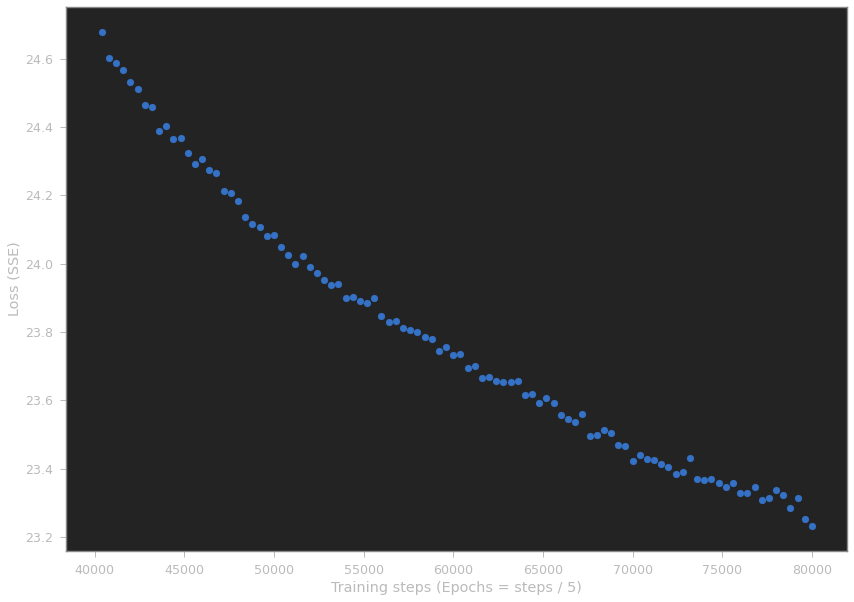

In [23]:
# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 5)')
plt.ylabel('Loss (SSE)')
plt.show()

In [24]:
pred = regressor.predict(input_fn=wx_input_fn(Xtest,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error

print("The Explained Variance: %.2f" % explained_variance_score(
                                            ytest, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            ytest, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            ytest, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 0.90
The Mean Absolute Error: 3.33 degrees Celcius
The Median Absolute Error: 2.64 degrees Celcius


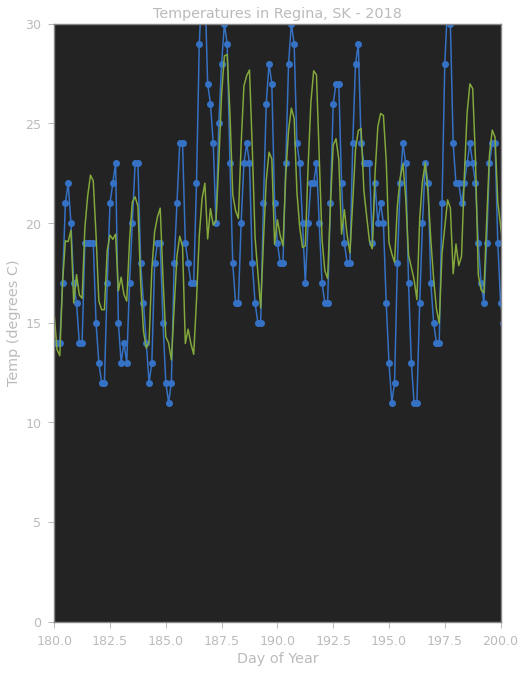

In [25]:
x = Xtest['date_delta']

df_final = pd.DataFrame({'x':x, 'yData':ytest, 'yFit': predictions, 'Residual': ytest-predictions})
df_final = df_final.sort_values(by=['x'])

fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df_final['x'],df_final['yData'],'o-')
axs2.set_ylabel('Temp (degrees C)')
axs2.set_xlabel('Day of Year')
axs2.set_title('Temperatures in Regina, SK - 2018')
axs2.set_xlim(180,200)
axs2.set_ylim(0,30)
axs2.plot(df_final['x'],df_final['yFit'])

plt.show()


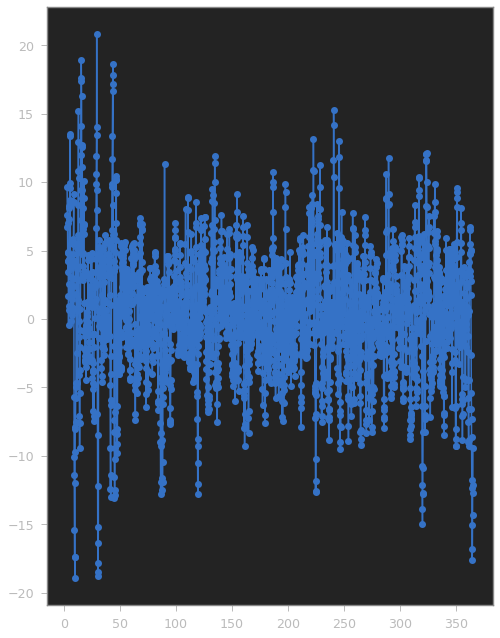

In [26]:
fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df_final['x'],df_final['yData']-df_final['yFit'],'o-')

(array([  2.,   1.,   0.,   2.,   2.,   0.,   1.,   1.,   0.,   2.,   0.,
          2.,   0.,   1.,   4.,   4.,   5.,   5.,   5.,   5.,   2.,   2.,
          2.,   4.,  11.,  11.,  11.,  16.,  20.,  25.,  26.,  26.,  24.,
         38.,  32.,  38.,  54.,  60.,  56.,  66.,  64.,  90.,  85.,  98.,
         99., 114., 106., 134., 129., 113., 147.,  92., 105.,  87.,  84.,
        113.,  81.,  70.,  70.,  67.,  55.,  58.,  41.,  40.,  29.,  14.,
         19.,  11.,  13.,  11.,  15.,  11.,   5.,   9.,   5.,   5.,   7.,
          3.,   5.,   3.,   4.,   3.,   3.,   2.,   0.,   1.,   1.,   0.,
          1.,   0.,   2.,   2.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,
          1.]), array([-19.39511657, -18.98877645, -18.58243633, -18.17609621,
        -17.76975609, -17.36341597, -16.95707585, -16.55073573,
        -16.14439561, -15.73805549, -15.33171537, -14.92537525,
        -14.51903513, -14.11269501, -13.70635489, -13.30001477,
        -12.89367465, -12.48733453, -12.08099441, -11.67465429,

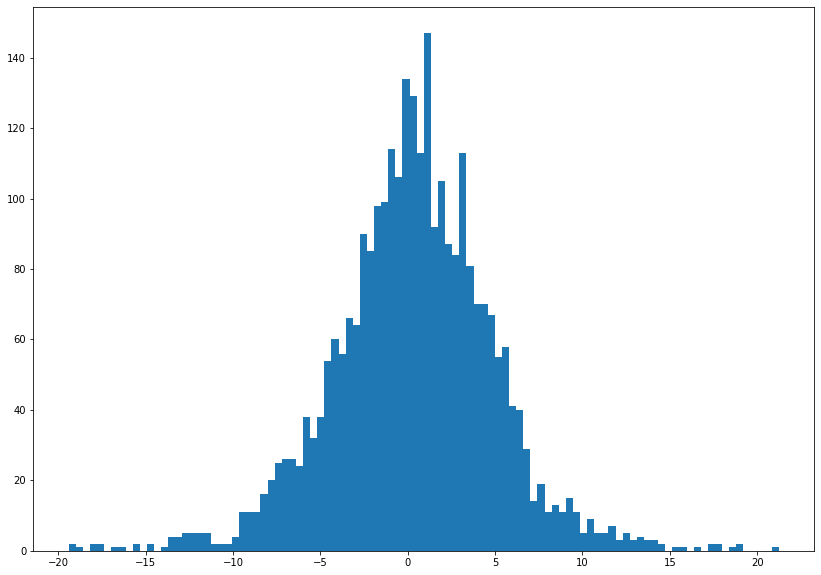

In [34]:
plt.hist(df_final['yData']-df_final['yFit'],bins=100)

0.35229923826907966 4.6007150772841605


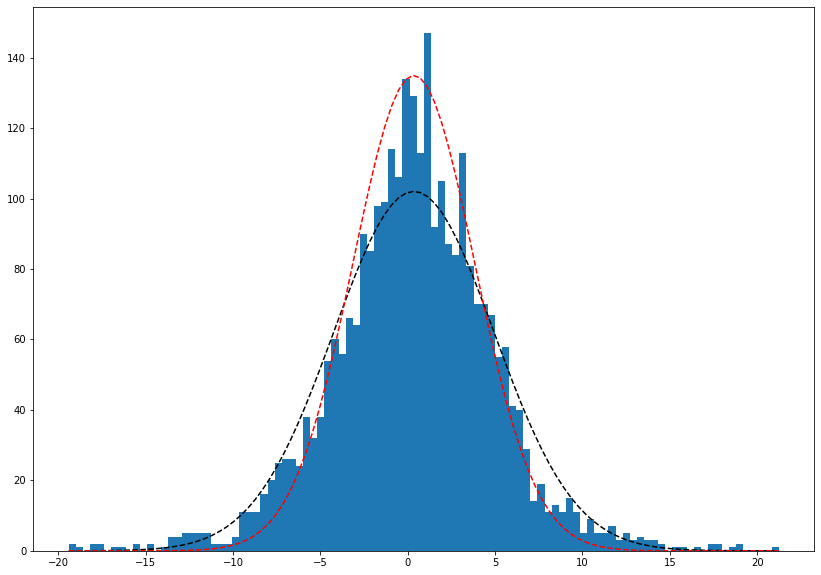

In [35]:
# best fit of data
data = df_final['yData']-df_final['yFit']
(mu, sigma) = stats.norm.fit(data)
print (mu,sigma)

# Empirical average and variance are computed
nbins = 100
avg = mu
var = sigma**2
N = len(df_final)
# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(np.min(data),np.max(data),nbins)
bin_size = (np.max(data) - np.min(data))/nbins
pdf_y = N*bin_size/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

var_mean = (mean_absolute_error(ytest, predictions)**2)
pdf_y2 = N*bin_size/np.sqrt(2*np.pi*var_mean)*np.exp(-0.5*(pdf_x-avg)**2/var_mean)

plt.hist(data,bins=100)
plt.plot(pdf_x,pdf_y,'k--')
plt.plot(pdf_x,pdf_y2,'r--')
plt.show()